# **Automatidata**
You are a data professional in a data consulting firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), was impressed with the work you have done and has requested that you build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.

# **Build a machine learning model**
In this project, I'm using tree-based modeling techniques to predict on a binary target class.

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.

**The goal** of this model is to predict whether or not a customer is a generous tipper.

This activity has three parts:

**Part 1:** Ethical considerations
* Consider the ethical implications of the request
* Should the objective of the model be adjusted?

**Part 2:** Feature engineering
* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling
* Build the models, evaluate them, and advise on next steps

# **PACE(Plan, Analyze, Construct, and Execute.) stages**

# **Plan**

1. What are you being asked to do?
2. What are the ethical implications of the model? What are the consequences of your model    making errors?

   * What is the likely effect of the model when it predicts a false negative (i.e., when       the model says a customer will give a tip, but they actually won't)?
   
   * What is the likely effect of the model when it predicts a false positive (i.e., when       the model says a customer will not give a tip, but they actually will)?

3. Do the benefits of such a model outweigh the potential problems?
4. Would you proceed with the request to build this model? Why or why not?
5. Can the objective be modified to make it less problematic?

**Response**

**Question 1:** 
Predict if a customer will not leave a tip.

**Question 2:**
Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happened often, drivers might not trust the app. Drivers are unlikely to pick up people who are predicted to not leave tips. Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company. Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.

**Question 3:**
It's not good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh the benefits.

**Question 4:**
No. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk.

**Question 5:**
We can build a model that predicts the most generous customers. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.

Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous—those who will tip 20% or more? Consider the following questions:

**2nd responses:**

**Question 1: What features do you need to make this prediction?**

Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.

**Question 2: What would be the target variable?**

The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

**Question 3:**

This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

**Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#This is the function that helps plot feature importance
from xgboost import plot_importance

# RUN THIS CELL TO SEE ALL COLUMNS 
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

#to avoid the warning
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#import dataset into dataframe
df = pd.read_csv('/kaggle/input/automatidata/2017_Yellow_Taxi_Trip_Data.csv')

#import predicted fares and mean distance and duration 
nyc_preds_means = pd.read_csv('/kaggle/input/automatidata/nyc_preds_means.csv')

In [3]:
#inspect the first few rows of df1
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [4]:
#inspect the first few rows of 'nyc_preds_means'
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


**JOIN THE TWO DATA FRAME**

In [5]:
df1 = df.merge(nyc_preds_means, left_index = True, right_index = True)
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


**EXPOLATORY DATA ANALYSIS(EDA)**

In [6]:
#Creating copy of the original datasets

df2 = df1.copy()

In [7]:
#Display the dataset's shape
df2.shape

(22699, 21)

In [8]:
#display basic info about the dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [9]:
# Check for missing data and duplicates using .isna() and .drop_duplicates()
df2.isna().sum()

Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
mean_duration            0
mean_distance            0
predicted_fare           0
dtype: int64

There is no duplicates and no missing value in the datasets

In [10]:
# Display descriptive stats about the data
df2.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502,14.460555,2.913313,12.979534
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295,10.080913,3.558993,9.706126
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000,0.000000,0.000000,2.934494
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,8.031481,1.010000,7.396030
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,11.556667,1.620000,9.560801
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000,17.321667,3.115625,13.933373
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000,88.783333,33.920000,89.171050


customers who pay cash generally have a tip amount of $0. To meet the modeling objective.

In [11]:
# Subset the data to isolate only customers who paid by credit card
df3 = df2[df2['payment_type']==1]

In [12]:
# Create tip % col
df3['tip_percent'] = round(df3['tip_amount'] / (df3['total_amount'] - df3['tip_amount']), 3)

In [13]:
#Now creating another column called generous. This will be the target variable. 
#The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

# Begin by making the generous column a copy of the tip_percent column.
# Reassign the column by converting it to Boolean (True/False).
# Reassign the column by converting Boolean to binary (1/0).

# Create 'generous' col (target)
df3['generous'] = df3['tip_percent']
df3['generous'] = (df3['generous'] >= 0.2)
df3['generous'] = df3['generous'].astype(int)

In [14]:
# Convert pickup and dropoff cols to datetime
df3['tpep_pickup_datetime'] = pd.to_datetime(df3['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df3['tpep_dropoff_datetime'] = pd.to_datetime(df3['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

In [15]:
# Create a 'day' col
df3['day'] = df3['tpep_pickup_datetime'].dt.day_name().str.lower()

In [16]:
# Create 'am_rush' col
df3['am_rush'] = df3['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df3['daytime'] = df3['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df3['pm_rush'] = df3['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df3['nighttime'] = df3['tpep_pickup_datetime'].dt.hour

In [17]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'am_rush' function to the 'am_rush' series
df3['am_rush'] = df3.apply(am_rush, axis=1)
df3['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

In [19]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

# Apply 'daytime' function to the 'daytime' series
df3['daytime'] = df3.apply(daytime, axis=1)

In [20]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val
# Apply 'pm_rush' function to the 'pm_rush' series
df3['pm_rush'] = df3.apply(pm_rush, axis=1)

In [21]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

# Apply 'nighttime' function to the 'nighttime' series
df3['nighttime'] = df3.apply(nighttime, axis=1)

In [22]:
# Create 'month' col
df3['month'] = df3['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [23]:
df3.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


In [24]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

**Drop columns¶**

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (generous) must remain in the data because it will get isolated as the y data for modeling

In [25]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df3 = df3.drop(drop_cols, axis=1)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


**Variable encoding**

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as RatecodeID and the pickup and dropoff locations. To make these columns recognizable to the get_dummies() function as categorical variables, you'll first need to convert them to type(str).

Define a variable called cols_to_str, which is a list of the numeric columns that contain categorical information and must be converted to string: RatecodeID, PULocationID, DOLocationID.
Write a for loop that converts each column in cols_to_str to string.

In [26]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df3[col] = df3[col].astype('str')

In [27]:
# Convert categoricals to binary
df4 = pd.get_dummies(df3, drop_first=True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


In [28]:
# Get class balance of 'generous' col
df4['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:

* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)
False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more—even when the original customer would have tipped generously.

**F1 score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.**

# **Construct**

**Task 3. Modeling**

Split the data
Now we're ready to model. The only remaining step is to split the data into features/target variable and training/testing data.

1. Define a variable y that isolates the target variable (generous).
2. Define a variable X that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [29]:
# Isolate target variable (y)
y = df4['generous']

# Isolate the features (X)
X = df4.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

**Random forest**

Begin with using GridSearchCV to tune a random forest model. 
1. Instantiate the random forest classifier rf and set the random state. 
2. Create a dictionary cv_params of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
*    max_depth
*    max_features
*    max_samples
*    min_samples_leaf
*    min_samples_split
*    n_estimators
3. Define a set scoring of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy). 
4. Instantiate the GridSearchCV object rf1. Pass to it as arguments: 
*    estimator=rf
*    param_grid=cv_params
*    scoring=scoring
*    cv: define the number of you cross-validation folds you want (cv=_)
*    refit: indicate which evaluation metric you want to use to select the model (refit=_)

**Note:** refit should be set to 'f1'.

In [30]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the training data.

**Note:** Depending on how many options you include in your search grid and the number of cross-validation folds you select, this could take a very long time—even hours. If you use 4-fold validation and include only one possible value for each hyperparameter and grow 300 trees to full depth, it should take about 5 minutes. If you add another value for GridSearch to check for, say, min_samples_split (so all hyperparameters now have 1 value except for min_samples_split, which has 2 possibilities), it would double the time to ~10 minutes. Each additional parameter would approximately double the time.

In [31]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 5min 50s, sys: 243 ms, total: 5min 50s
Wall time: 5min 51s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'precision', 'recall', 'accuracy', 'f1'})

In [32]:
import pickle 

# Define a path to the folder where you want to save the model
path = '/kaggle/working/'

In [33]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [34]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [35]:
#Examine the best average score across all the validation folds.
# Examine best score
rf1.best_score_

0.7136009788848705

In [36]:
#Examine the best combination of hyperparameters.
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [37]:
#Use the make_results() function to output all of the scores of your model. Note that it accepts three arguments.
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [38]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233


This is an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case. Optional: try to improve the scores. It's worth trying, especially to practice searching over different hyperparameters.

**For this project**, I will use several models to predict on the test data. Remember that this decision comes with a trade-off. What is the benefit of this? What is the drawback?

**The benefit** of using multiple models to predict on the test data is that you can compare models using data that was not used to train/tune hyperparameters. This reduces the risk of selecting a model based on how well it fit the training data.

**The drawback** of using the final test data to select a model is that, by using the unseen data to make a decision about which model to use, you no longer have a truly unbiased idea of how your model would be expected to perform on new data. In this case, think of final model selection as another way of "tuning" your model.

In [39]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [40]:
#Use get_test_scores() function you will use to output the scores of the model on the test data.
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [41]:
#Use the get_test_scores() function to generate the scores on the test data. Assign the results to rf_test_scores.
#Call rf_test_scores to output the results.

# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538


**Question:** How do your test results compare to your validation results?

**Response:** All scores increased by at most ~0.02.

**XGBoost**
Try to improve my scores using an XGBoost model.

1. Instantiate the XGBoost classifier xgb and set objective='binary:logistic'. Also set the random state.
2. Create a dictionary cv_params of the following hyperparameters and their corresponding values to tune:

     * max_depth
     * min_child_weight
     * learning_rate
     * n_estimators
     
3. Define a set scoring of scoring metrics for grid search to capture (precision, recall,    F1 score, and accuracy).
4. Instantiate the GridSearchCV object xgb1. Pass to it as arguments:

     * estimator=xgb
     * param_grid=cv_params
     * scoring=scoring
     * cv: define the number of cross-validation folds you want (cv=_)
     * refit: indicate which evaluation metric you want to use to select the model (refit='f1')

In [42]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [43]:
%%time
#Now fit the model to the X_train and y_train data
xgb1.fit(X_train, y_train)

CPU times: user 1min 52s, sys: 467 ms, total: 1min 53s
Wall time: 31.4 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring={'precision', 'recall', 'accuracy', 'f1'})

In [44]:
# Examine best score
xgb1.best_score_

0.6955124635485908

In [45]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

In [46]:
#XGB CV results
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538
0,XGB CV,0.669726,0.723553,0.695512,0.666557


Use the model to predict on the test data. Assign the results to a variable called xgb_preds.

In [47]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

**XGB test results¶**

Use the get_test_scores() function to generate the scores on the test data. Assign the results to xgb_test_scores.
Call xgb_test_scores to output the results.

In [48]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538
0,XGB CV,0.669726,0.723553,0.695512,0.666557
0,XGB test,0.677219,0.745488,0.709716,0.679004


**The F1 score** is ~0.01 lower than the random forest model. Both models are acceptable, but the random forest model is the champion.

Plot a confusion matrix of the champion model's predictions on the test data.

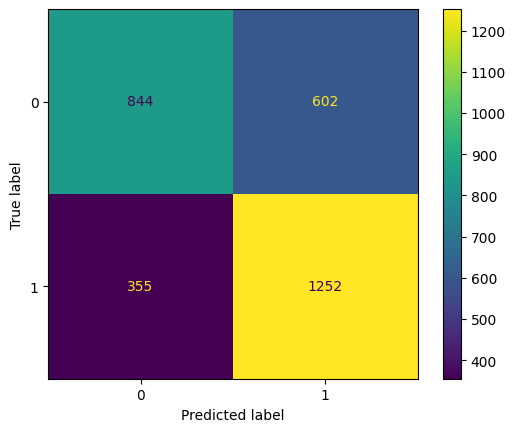

In [49]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(values_format='');

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

**Feature importance**

Use the feature_importances_ attribute of the best estimator object to inspect the features of my final model. Then sort them and plot the most important ones.

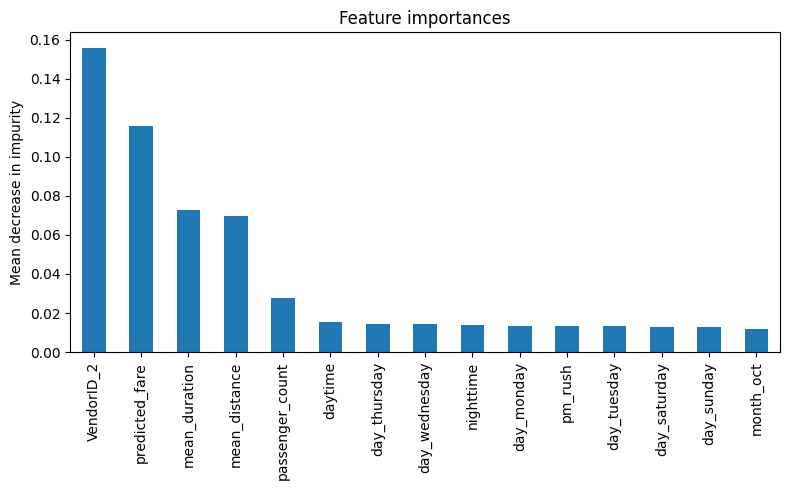

In [50]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

## **Execute**

# **Task 4. Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

**1. Would you recommend using this model? Why or why not?**

Yes, this is model performs acceptably. Its F1 score was 0.7235 and it had an overall accuracy of 0.6865. It correctly identified ~78% of the actual responders in the test set, which is 48% better than a random guess. It may be worthwhile to test the model with a select group of taxi drivers to get feedback.

**2. What was your highest scoring model doing? Can you explain how it was making predictions?**

Unfortunately, random forest is not the most transparent machine learning algorithm. We know that VendorID, predicted_fare, mean_duration, and mean_distance are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that VendorID is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further.

**3. Are there new features that you can engineer that might improve model performance?**

There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of $5) / fare amount. For example, if the fare were $12, the value in this column would be 0.25, because $12 to the nearest higher multiple of $5 ($15) is $3, and $3 divided by $12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of $5 may have lower tip percentages than those with fare values just over a multiple of $5. We could also do the same thing for fares to the nearest $10.

𝑟𝑜𝑢𝑛𝑑5_𝑟𝑎𝑡𝑖𝑜 = 𝑎𝑚𝑜𝑢𝑛𝑡 𝑜𝑓 𝑚𝑜𝑛𝑒𝑦 𝑓𝑟𝑜𝑚 𝑡ℎ𝑒 𝑓𝑎𝑟𝑒 𝑎𝑚𝑜𝑢𝑛𝑡 𝑡𝑜 𝑡ℎ𝑒 𝑛𝑒𝑎𝑟𝑒𝑠𝑡 ℎ𝑖𝑔ℎ𝑒𝑟 𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑒 𝑜𝑓 $5/𝑓𝑎𝑟𝑒 𝑎𝑚𝑜𝑢𝑛𝑡
 
**4. What features would you want to have that would likely improve the performance of your model?**

It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash. It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.